In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
"""
!wget https://zenodo.org/record/2539456/files/plasticc_train_lightcurves.csv.gz
!wget https://zenodo.org/record/2539456/files/plasticc_train_metadata.csv.gz
!gzip -d plasticc_train_lightcurves.csv.gz
!gzip -d plasticc_train_metadata.csv.gz
!mv plasticc_train_lightcurves.csv ../Data
!mv plasticc_train_metadata.csv ../Data
"""

'\n!wget https://zenodo.org/record/2539456/files/plasticc_train_lightcurves.csv.gz\n!wget https://zenodo.org/record/2539456/files/plasticc_train_metadata.csv.gz\n!gzip -d plasticc_train_lightcurves.csv.gz\n!gzip -d plasticc_train_metadata.csv.gz\n!mv plasticc_train_lightcurves.csv ../Data\n!mv plasticc_train_metadata.csv ../Data\n'

In [3]:
DATA_DIR = "../Data/"

In [162]:
class LightCurve():
    _pbnames = ['u','g','r','i','z','y']
    _cad_num = {"low":0, "high":1}
    _targets = [6, 15, 16, 42, 52, 53, 62, 64, 65, 67, 88, 90, 92, 95]
    
    def __init__(self, data_file="plasticc_train_lightcurves.csv", target_file='plasticc_train_metadata.csv', cadence="low"):
        raw_data = pd.read_csv(os.path.join(DATA_DIR, data_file))
        target_data = pd.read_csv(os.path.join(DATA_DIR, target_file))
     
        self.cadence = cadence
        self.data_cadence = target_data[target_data["ddf_bool"]==self._cad_num[cadence]]
        self.targets, self.objects = self.data_cadence['target'].values, self.data_cadence['object_id'].values
        
        self.light_curves = raw_data[raw_data["detected_bool"]==self._cad_num[cadence]]
        self.ids = {_id: self.objects[_id] for _id in np.arange(len(self.objects)) }
    
    def get_length(self):
        return len(self.ids)
   
    def show_lightcurves_by_id(self, _id, band="all"):
        object_id = self.ids[_id]
        curves = self.light_curves[self.light_curves['object_id']==object_id]
        if band != "all":
            index_band = self._pbnames.index(band)
            curve_in_band = curves[curves['passband']==index_band]
            curve_x = curve_in_band['mjd'].values
            curve_y = curve_in_band['flux'].values
            plt.scatter(curve_x, curve_y)
            plt.title(f"{object_id=}")
            plt.show()
            return
        
        for index_band in range(len(self._pbnames)):
            curve_in_band = curves[curves['passband']==index_band]
            curves_x = curve_in_band['mjd'].values
            curves_y = curve_in_band['flux'].values
            plt.scatter(curves_x, curves_y)
            plt.title(f"{object_id=}")
        plt.show()
        return
    
    def get_matrix_lightcurve(self, _id, band_height=1, band="all"):
        print(f"number of targets = {len(self.targets)}", f"number of ids = {len(self.ids)}")
        object_id = self.ids[_id]
        curves = self.light_curves[self.light_curves['object_id']==object_id]
        k = 6 if band=="all" else 1
        if self.cadence == "high":
            data = np.zeros((k*band_height,1200))
        elif self.cadence == "low":
            data = np.zeros((k*band_height,1200))
        
        if band != "all":
            index_band = self._pbnames.index(band)
            curve = self.light_curves[self.light_curves['object_id']==object_id]
            data_band = curve[curve["passband"]==index_band][['mjd','flux']].values

            data_band[:,0] -= data_band[:,0].min()
            data_band[:,0] = np.round(data_band[:,0])

            for i in range(band_height):
                data[i][data_band[:,0].astype(int)] = data_band[:,1]
        
            return data, self._targets.index(self.targets[_id])
    
        
        for index_band in range(len(self._pbnames)):
            curve = self.light_curves[self.light_curves['object_id']==object_id]
            data_band = curve[curve["passband"]==index_band][['mjd','flux']].values
            if len(data_band)>900:
                return data, -1
            if len(data_band)==0: 
                continue
            # --- normalize time --- #
            data_band[:,0] -= data_band[:,0].min()
            data_band[:,0] = np.round(data_band[:,0])
            # ---------------------- #
            for m in np.arange(index_band*band_height, band_height*(index_band+1)):
                data[m,data_band[:,0].astype(int)] = data_band[:,1]
            
            """
            for i in np.arange(len(data[0])):
                if data[index_band][i].max() != 0:
                    data[index_band][i] -= data.min()
                    data[index_band][i] = data[index_band][i]/data.max()*255
             """
        return data, self._targets.index(self.targets[_id])
    
    def compress_matrix_lightcurve(self, _id, size=(6, 100, 1)):
        band_height = size[2]
        matrix, target = self.get_matrix_lightcurve(_id, band_height)
        print(f"print shape matrix = {matrix.shape}")
        
        zip_matrix = np.zeros((size[0], size[1]))
        for row in np.arange(0, matrix.shape[0], band_height):
            for col in np.arange(0, matrix.shape[1], matrix.shape[1]//size[1]):
                data, n = 0, 0
                for sub_col in np.arange(col, col + matrix.shape[1]//size[1]):
                    data += matrix[row, sub_col] 
                    n += 1
                for sub_row in np.arange(row, row + band_height):
                    zip_matrix[sub_row, col//(matrix.shape[1]//size[1])] = data/n
                    
        zip_matrix -= zip_matrix.min()
        zip_matrix = zip_matrix/zip_matrix.max()*255
        
        return zip_matrix, int(target)
    
    def load_all(self, length=30, size=(6, 200, 1)):
        all_data = np.zeros((length, size[0], size[1]))
        all_targets = np.zeros((length, 1))
        for i in np.arange(length):
            all_data[i], all_targets[i] = self.compress_matrix_lightcurve(i, size)
        return all_data, all_targets.reshape(1,-1)

number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
12


(0.0, 255.0)

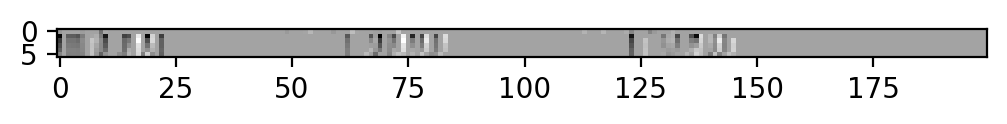

In [161]:
lc = LightCurve("plasticc_train_lightcurves.csv", "plasticc_train_metadata.csv", "high")
plt.figure(dpi=200)
zip_data, target = lc.compress_matrix_lightcurve(0, size=(6,200,1))
print(target)
plt.imshow(zip_data, cmap='gray')
zip_data.min(), zip_data.max()

In [ ]:
lc = LightCurve("plasticc_train_lightcurves.csv", "plasticc_train_metadata.csv", "high")
lc.show_lightcurves_by_id(0, "all")

In [16]:
targets = pd.read_csv("../Data/plasticc_train_metadata.csv")

In [17]:
targets

,object_id,ra,decl,ddf_bool,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target,...,true_rv,true_av,true_peakmjd,libid_cadence,tflux_u,tflux_g,tflux_r,tflux_i,tflux_z,tflux_y
0,615,349.0461,-61.9438,1,0.000,0.000,0.000,-9.000,0.017,92,...,0.0,0.000,59570.000,69,484.7,3286.7,3214.1,3039.7,2854.5,2837.0
1,713,53.0859,-27.7844,1,1.818,1.627,0.255,45.406,0.007,88,...,0.0,0.000,59570.000,34,108.7,117.7,119.9,149.6,147.9,150.5
2,730,33.5742,-6.5796,1,0.232,0.226,0.016,40.256,0.021,42,...,0.0,0.000,60444.379,9,0.0,0.0,0.0,0.0,0.0,0.0
3,745,0.1899,-45.5867,1,0.304,0.281,1.152,40.795,0.007,90,...,0.0,0.000,60130.453,38,0.0,0.0,0.0,0.0,0.0,0.0
4,1124,352.7113,-63.8237,1,0.193,0.241,0.018,40.417,0.024,90,...,0.0,0.000,60452.641,1,0.0,0.0,0.0,0.0,0.0,0.0
5,1227,35.6836,-5.3794,1,0.000,0.000,0.000,-9.000,0.020,65,...,0.0,0.000,59570.000,47,2.3,11.6,31.6,240.0,632.4,1187.7
6,1598,347.8467,-64.7609,1,0.135,0.182,0.030,39.728,0.019,90,...,0.0,0.000,60628.816,20,0.0,0.0,0.0,0.0,0.0,0.0
7,1632,348.5959,-63.0726,1,0.686,0.701,0.010,43.152,0.021,42,...,3.1,0.051,59602.090,93,0.0,0.0,0.0,0.0,0.0,0.0
8,1920,149.4141,3.4338,1,0.309,0.323,0.336,41.140,0.027,90,...,0.0,0.000,59996.625,107,0.0,0.0,0.0,0.0,0.0,0.0
9,1926,149.4141,1.9401,1,0.000,0.000,0.000,-9.000,0.018,65,...,0.0,0.000,59570.000,15,16.6,130.6,450.4,2237.3,4903.2,8229.6


# preprocessing data

In [150]:
import torch

In [151]:
from sklearn.model_selection import train_test_split

In [176]:
lc = LightCurve("plasticc_train_lightcurves.csv", "plasticc_train_metadata.csv", "high")
length = lc.get_length()

In [182]:
data, targets = lc.load_all(length)

number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)

print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116

print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116

print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116

number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)

print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116

number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)

number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)

number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)

number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)

print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116

number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)

number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)

print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116

print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116

print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116

print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116

number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)

print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116

In [183]:
data.shape

(2116, 6, 200)

In [184]:
X_train, X_test, y_train, y_test = train_test_split(
    data, 
    targets[0], 
    test_size=0.3, 
    shuffle=True)

In [185]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train, 
    y_train, 
    test_size=0.2, 
    shuffle=True)

In [186]:
print(f"train size {X_train.shape} validation size {X_val.shape} test_size {X_test.shape}")

train size (1184, 6, 200) validation size (297, 6, 200) test_size (635, 6, 200)


In [187]:
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
X_val = torch.FloatTensor(X_val)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)
y_val = torch.LongTensor(y_val)

In [188]:
y_val

tensor([ 6,  2,  9, 11, 10,  3, 12, 11,  8,  8, 11,  6,  2, 11, 10,  9, 11,  2,
        11, 11,  3,  4,  8,  3, 10, 12,  8, 11,  9,  6, 11, 11,  4,  2,  8,  3,
         3,  3, 11, 10, 11,  2, 11,  8,  6, 11,  6, 11,  3, 10, 13,  8, 11,  8,
        11,  2,  3,  1, 11, 11,  9,  8,  6, 11, 11, 11,  8,  8, 11, 11,  3,  2,
         3,  2,  8,  3, 11,  3,  3, 11,  8, 11, 11,  2, 11,  3,  6, 11, 11,  6,
         2,  8,  6, 10,  2, 11,  6,  8, 11, 11,  3, 11,  8,  3, 10, 11, 11, 11,
        11,  8, 11, 11, 11,  3, 11,  3, 13, 10,  8, 10, 10, 11, 11,  4, 11, 12,
         8, 11,  3, 11, 11,  8,  6, 11, 11,  6, 10,  8, 12,  9,  2,  8,  6,  6,
        11, 11,  3,  5,  8,  8, 11,  9, 11, 11,  8,  0, 11,  8, 11, 13, 11, 11,
        11, 10,  9, 11, 11, 11,  3,  8, 10, 11, 11,  8, 10,  3, 11, 11, 12, 11,
         7, 11, 11, 11, 11,  3,  6,  8,  3, 11,  9,  8,  9,  8,  8, 11, 10, 12,
         8,  2, 11,  3,  8, 11,  8,  3,  7,  3,  6, 11,  8,  3, 11, 11, 11, 12,
         8, 10, 11,  8,  6, 11,  1, 11, 

In [189]:
X_train.shape

torch.Size([1184, 6, 200])

In [190]:
X_train = X_train.unsqueeze(1).float()
X_test = X_test.unsqueeze(1).float()
X_val = X_val.unsqueeze(1).float()

In [191]:
X_train.shape

torch.Size([1184, 1, 6, 200])

# Neural Net

In [321]:
class ConvNet(torch.nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        
        self.conv1 = torch.nn.Conv2d(
            in_channels=1, out_channels=1, kernel_size=(1,5), padding=0)
        self.act1  = torch.nn.Tanh()
        self.pool1 = torch.nn.MaxPool2d(kernel_size=(1,2), stride=1)
       
        self.conv2 = torch.nn.Conv2d(
            in_channels=1, out_channels=1, kernel_size=(1,5), padding=0)
        self.act2  = torch.nn.Tanh()
        self.pool2 = torch.nn.MaxPool2d(kernel_size=(1,2), stride=1)
        
        self.fc1   = torch.nn.Linear(190*6*1, 120)
        self.act3  = torch.nn.Tanh()
        
        self.fc2   = torch.nn.Linear(120, 84)
        self.act4  = torch.nn.Tanh()
        
        self.fc3   = torch.nn.Linear(84, 14)
    
    def forward(self, x):
        
        x = self.conv1(x)
        #print(f"size after first conv = {x.shape}")
        x = self.act1(x)
        x = self.pool1(x)
        #print(f"size after first pool = {x.shape}")
        
        x = self.conv2(x)
        #print(f"size after second conv = {x.shape}")
        x = self.act2(x)
        x = self.pool2(x)
        #print(f"size after second pool = {x.shape}")
        
        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))
        #print(x.shape)
        x = self.fc1(x)
        x = self.act3(x)
        x = self.fc2(x)
        x = self.act4(x)
        x = self.fc3(x)
        
        return x
    

In [390]:
net = ConvNet()
device = torch.device('cpu')
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1.0e-3)

In [391]:
batch_size = 300
num_epoch = 1000

train_accuracy_history = []
train_loss_history = []
val_accuracy_history = []
val_loss_history = []

X_val = X_val.to(device)
y_val = y_val.to(device)
X_train = X_train.to(device)
y_train = y_train.to(device)

for epoch in range(num_epoch):
    order = np.random.permutation(len(X_train))
    for start_index in range(0, len(X_train), batch_size):
        optimizer.zero_grad()
        
        batch_indexes = order[start_index:start_index+batch_size]
        
        X_batch = X_train[batch_indexes].to(device)
        y_batch = y_train[batch_indexes].to(device)
        
        preds = net.forward(X_batch) 
        
        loss_value = loss(preds, y_batch)
        loss_value.backward()
        
        optimizer.step()
        
    test_preds = net.forward(X_val)
    val_loss_history.append(loss(test_preds, y_val).data.cpu())
    accuracy = (test_preds.argmax(dim=1) == y_val).float().mean().data.cpu()
    val_accuracy_history.append(accuracy)
    
    train_preds = net.forward(X_train)
    train_loss_history.append(loss(train_preds, y_train).data.cpu())
    train_accuracy = (train_preds.argmax(dim=1) == y_train).float().mean().data.cpu()
    train_accuracy_history.append(train_accuracy)
    
    print(f'current epoch {epoch}/{num_epoch} val accuracy = {accuracy}')

current epoch 0/100 val accuracy = 0.4579124450683594
current epoch 1/100 val accuracy = 0.4579124450683594
current epoch 2/100 val accuracy = 0.4579124450683594
current epoch 3/100 val accuracy = 0.4579124450683594
current epoch 4/100 val accuracy = 0.4579124450683594
current epoch 5/100 val accuracy = 0.4579124450683594
current epoch 6/100 val accuracy = 0.4579124450683594
current epoch 7/100 val accuracy = 0.4579124450683594
current epoch 8/100 val accuracy = 0.4579124450683594
current epoch 9/100 val accuracy = 0.4579124450683594
current epoch 10/100 val accuracy = 0.4579124450683594
current epoch 11/100 val accuracy = 0.4579124450683594
current epoch 12/100 val accuracy = 0.4579124450683594
current epoch 13/100 val accuracy = 0.4579124450683594
current epoch 14/100 val accuracy = 0.4579124450683594
current epoch 15/100 val accuracy = 0.4612794518470764
current epoch 16/100 val accuracy = 0.47138047218322754
current epoch 17/100 val accuracy = 0.5319865345954895
current epoch 18/10

current epoch 149/100 val accuracy = 0.6498316526412964
current epoch 150/100 val accuracy = 0.619528591632843
current epoch 151/100 val accuracy = 0.6565656661987305
current epoch 152/100 val accuracy = 0.6397306323051453
current epoch 153/100 val accuracy = 0.6329966187477112
current epoch 154/100 val accuracy = 0.6430976390838623
current epoch 155/100 val accuracy = 0.6464646458625793
current epoch 156/100 val accuracy = 0.6464646458625793
current epoch 157/100 val accuracy = 0.6565656661987305
current epoch 158/100 val accuracy = 0.6498316526412964
current epoch 159/100 val accuracy = 0.6632996797561646
current epoch 160/100 val accuracy = 0.6329966187477112
current epoch 161/100 val accuracy = 0.6565656661987305
current epoch 162/100 val accuracy = 0.6531986594200134
current epoch 163/100 val accuracy = 0.6430976390838623
current epoch 164/100 val accuracy = 0.6531986594200134
current epoch 165/100 val accuracy = 0.6565656661987305
current epoch 166/100 val accuracy = 0.6464646458

current epoch 297/100 val accuracy = 0.6161616444587708
current epoch 298/100 val accuracy = 0.6464646458625793
current epoch 299/100 val accuracy = 0.5791245698928833
current epoch 300/100 val accuracy = 0.6397306323051453
current epoch 301/100 val accuracy = 0.6329966187477112
current epoch 302/100 val accuracy = 0.619528591632843
current epoch 303/100 val accuracy = 0.6430976390838623
current epoch 304/100 val accuracy = 0.6262626051902771
current epoch 305/100 val accuracy = 0.6430976390838623
current epoch 306/100 val accuracy = 0.6734007000923157
current epoch 307/100 val accuracy = 0.6498316526412964
current epoch 308/100 val accuracy = 0.6498316526412964
current epoch 309/100 val accuracy = 0.6700336933135986
current epoch 310/100 val accuracy = 0.6464646458625793
current epoch 311/100 val accuracy = 0.6666666865348816
current epoch 312/100 val accuracy = 0.6161616444587708
current epoch 313/100 val accuracy = 0.6026936173439026
current epoch 314/100 val accuracy = 0.6734007000

current epoch 444/100 val accuracy = 0.6599326729774475
current epoch 445/100 val accuracy = 0.680134654045105
current epoch 446/100 val accuracy = 0.680134654045105
current epoch 447/100 val accuracy = 0.7037037014961243
current epoch 448/100 val accuracy = 0.6430976390838623
current epoch 449/100 val accuracy = 0.6565656661987305
current epoch 450/100 val accuracy = 0.6599326729774475
current epoch 451/100 val accuracy = 0.6632996797561646
current epoch 452/100 val accuracy = 0.6296296119689941
current epoch 453/100 val accuracy = 0.6734007000923157
current epoch 454/100 val accuracy = 0.6969696879386902
current epoch 455/100 val accuracy = 0.6632996797561646
current epoch 456/100 val accuracy = 0.6565656661987305
current epoch 457/100 val accuracy = 0.6767676472663879
current epoch 458/100 val accuracy = 0.6700336933135986
current epoch 459/100 val accuracy = 0.7070707082748413
current epoch 460/100 val accuracy = 0.6430976390838623
current epoch 461/100 val accuracy = 0.68686866760

current epoch 592/100 val accuracy = 0.6228955984115601
current epoch 593/100 val accuracy = 0.6767676472663879
current epoch 594/100 val accuracy = 0.6632996797561646
current epoch 595/100 val accuracy = 0.6329966187477112
current epoch 596/100 val accuracy = 0.6531986594200134
current epoch 597/100 val accuracy = 0.6868686676025391
current epoch 598/100 val accuracy = 0.6666666865348816
current epoch 599/100 val accuracy = 0.6430976390838623
current epoch 600/100 val accuracy = 0.6767676472663879
current epoch 601/100 val accuracy = 0.5690235495567322
current epoch 602/100 val accuracy = 0.5521885752677917
current epoch 603/100 val accuracy = 0.6296296119689941
current epoch 604/100 val accuracy = 0.5690235495567322
current epoch 605/100 val accuracy = 0.6026936173439026
current epoch 606/100 val accuracy = 0.6464646458625793
current epoch 607/100 val accuracy = 0.5993266105651855
current epoch 608/100 val accuracy = 0.5892255902290344
current epoch 609/100 val accuracy = 0.643097639

current epoch 739/100 val accuracy = 0.6329966187477112
current epoch 740/100 val accuracy = 0.6666666865348816
current epoch 741/100 val accuracy = 0.6094276309013367
current epoch 742/100 val accuracy = 0.6599326729774475
current epoch 743/100 val accuracy = 0.6565656661987305
current epoch 744/100 val accuracy = 0.6228955984115601
current epoch 745/100 val accuracy = 0.6734007000923157
current epoch 746/100 val accuracy = 0.619528591632843
current epoch 747/100 val accuracy = 0.6464646458625793
current epoch 748/100 val accuracy = 0.6565656661987305
current epoch 749/100 val accuracy = 0.6262626051902771
current epoch 750/100 val accuracy = 0.6734007000923157
current epoch 751/100 val accuracy = 0.6127946376800537
current epoch 752/100 val accuracy = 0.6464646458625793
current epoch 753/100 val accuracy = 0.6464646458625793
current epoch 754/100 val accuracy = 0.5993266105651855
current epoch 755/100 val accuracy = 0.6902356743812561
current epoch 756/100 val accuracy = 0.6161616444

current epoch 887/100 val accuracy = 0.6363636255264282
current epoch 888/100 val accuracy = 0.6498316526412964
current epoch 889/100 val accuracy = 0.6228955984115601
current epoch 890/100 val accuracy = 0.6430976390838623
current epoch 891/100 val accuracy = 0.6531986594200134
current epoch 892/100 val accuracy = 0.5892255902290344
current epoch 893/100 val accuracy = 0.6734007000923157
current epoch 894/100 val accuracy = 0.6127946376800537
current epoch 895/100 val accuracy = 0.6531986594200134
current epoch 896/100 val accuracy = 0.6363636255264282
current epoch 897/100 val accuracy = 0.6363636255264282
current epoch 898/100 val accuracy = 0.6599326729774475
current epoch 899/100 val accuracy = 0.6329966187477112
current epoch 900/100 val accuracy = 0.6329966187477112
current epoch 901/100 val accuracy = 0.6329966187477112
current epoch 902/100 val accuracy = 0.6296296119689941
current epoch 903/100 val accuracy = 0.6363636255264282
current epoch 904/100 val accuracy = 0.602693617

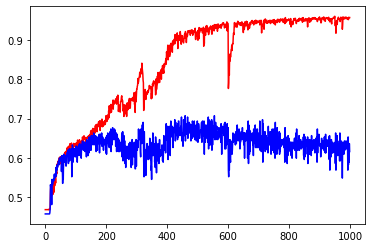

In [392]:
plt.plot(train_accuracy_history, 'r')
plt.plot(val_accuracy_history, 'b')

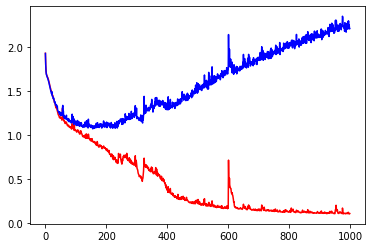

In [393]:
plt.plot(train_loss_history, 'r')
plt.plot(val_loss_history, 'b')

In [427]:
preds = net.forward(X_test[122].unsqueeze(1)) 

In [428]:
preds.argmax(dim=1)

tensor([8])

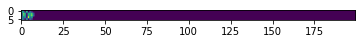

In [396]:
plt.imshow(X_test[57][0])

In [429]:
y_test[122]

tensor(8)